# Collecting Guides in `gggrid()`

The `guides` parameter controls how legends and colorbars are handled when arranging plots in a grid.

**`guides="auto"`** (default)  
Keep guides in subplots by default. However, if this grid is nested inside another grid that uses `guides="collect"`, pass the guides up for collection at that higher level.

**`guides="collect"`**  
Collect all guides (legends and colorbars) from subplots and place them alongside the grid figure, automatically removing duplicates.

**`guides="keep"`**  
Keep guides in their original subplots. No collection occurs at this level, even if an outer grid requests collection.

#### Duplicate Detection

Guides are compared by their visual appearance:

**For legends:**  
Two legends are considered duplicates if they have identical 
- title
- labels
- all aesthetic values (colors, shapes, sizes, line types, etc.)

**For colorbars:**  
Two colorbars are considered duplicates if they have identical 
- title
- domain limits
- breaks (tick positions)
- color gradient

Note: Colorbars from different data ranges typically have different limits and will not merge without manual harmonization.

In [1]:
%useLatestDescriptors
%use dataframe
%use lets-plot(output="js, png")

In [2]:
LetsPlot.getInfo()

Lets-Plot Kotlin API v.4.12.0. Frontend: Notebook with dynamically loaded JS. Lets-Plot JS v.4.8.1.
Outputs: Web (HTML+JS), Static PNG (hidden)

In [3]:
// Helper functions

fun <T> DataFrame<T>.sample(n: Int, randomState: Long? = null): DataFrame<T> {
    val rng = randomState?.let { java.util.Random(it) } ?: java.util.Random()
    return this.rows().shuffled(rng).take(n).toDataFrame()
}

fun <T> DataFrame<T>.shape(): Pair<Int, Int> =
    Pair(this.rowsCount(), this.columnsCount())

In [4]:
val df = DataFrame.readCSV("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/refs/heads/master/data/diamonds.csv")
println("Source: ${df.shape()}")

val sampleDf = df.sample(1_000, randomState = 42)
val diamonds = sampleDf.toMap()

println("Sampled: ${sampleDf.shape()}")
sampleDf.head()

Source: (53940, 10)
Sampled: (1000, 10)


carat,cut,color,clarity,depth,table,price,x,y,z
1.410000,Good,G,SI1,63.700000,57.000000,7738,7.130000,7.030000,4.510000
1.210000,Premium,F,SI2,61.800000,59.000000,4472,6.820000,6.770000,4.200000
0.700000,Very Good,E,SI2,60.100000,56.000000,2290,5.760000,5.790000,3.470000
0.710000,Ideal,I,VS2,62.100000,59.000000,2315,5.730000,5.700000,3.550000
0.350000,Very Good,H,VVS2,63.000000,55.000000,706,4.480000,4.500000,2.830000


#### 1. Collecting Legends


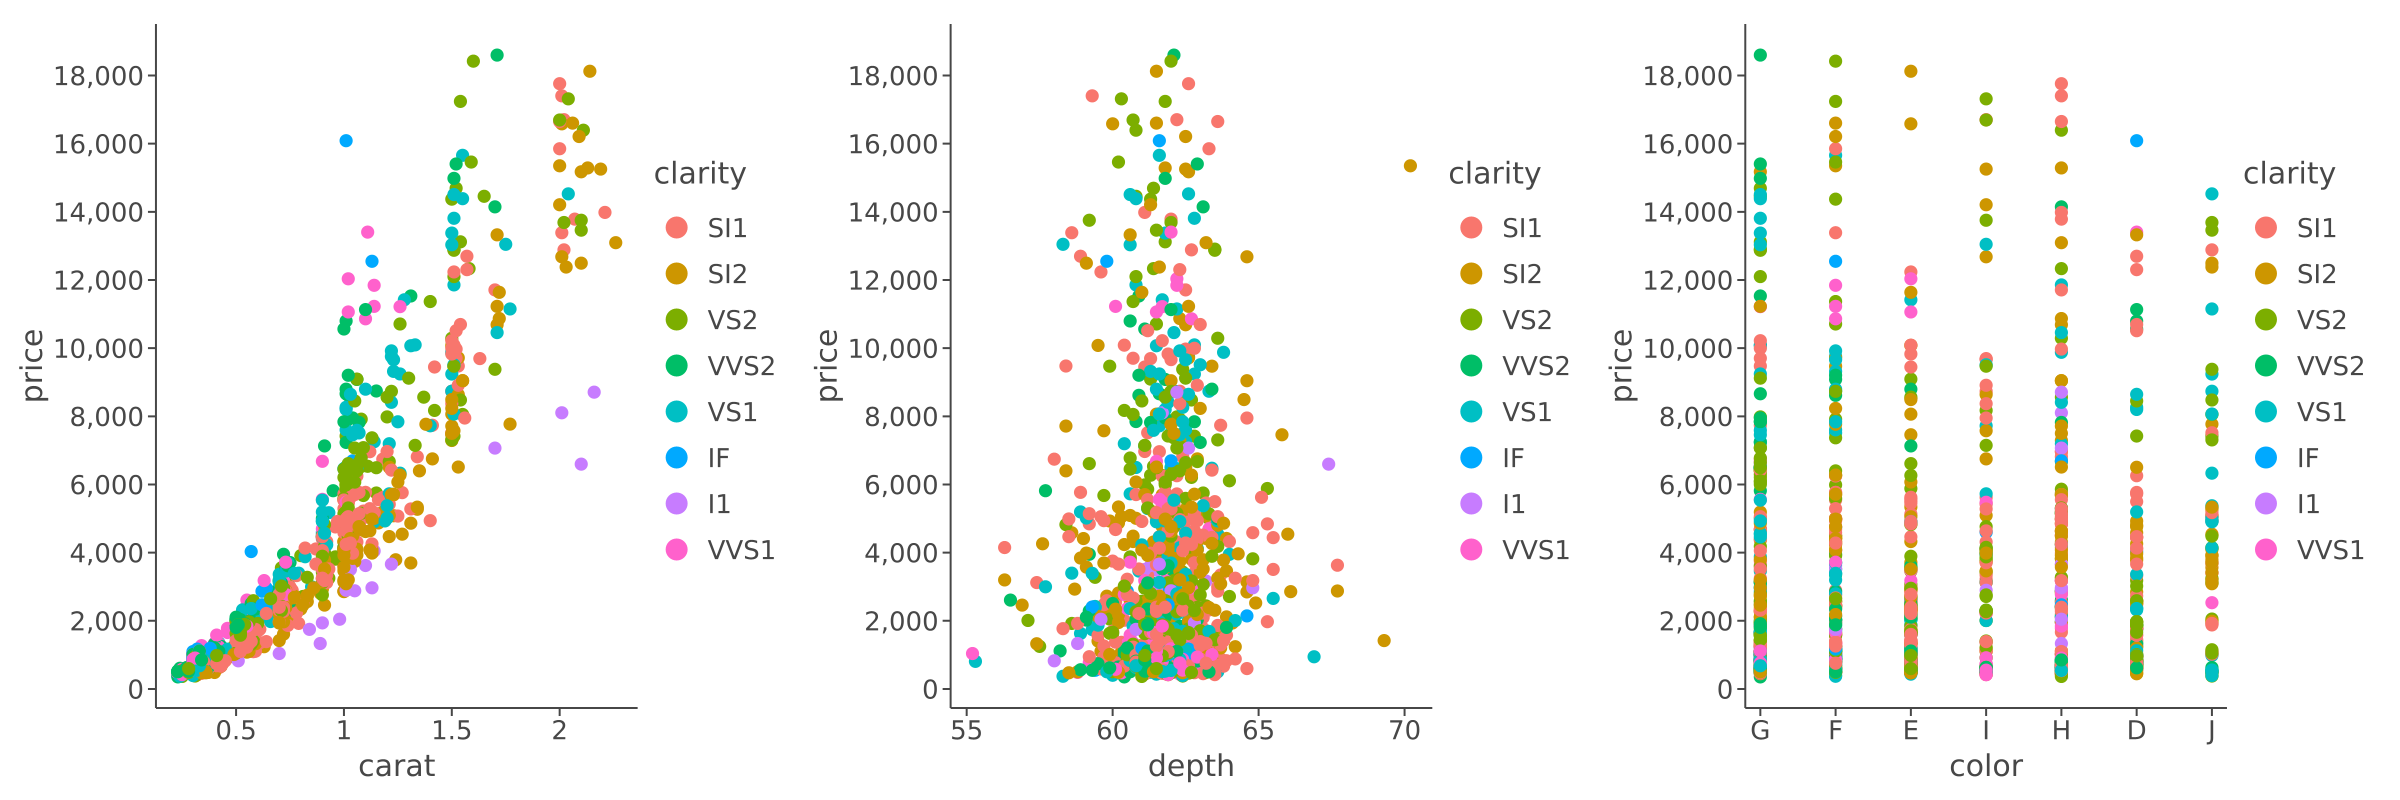

In [5]:
// Create three plots that share the same color aesthetic ('clarity')

val clarityP =
    letsPlot(diamonds) { y = "price"; color = "clarity" } +
        scaleColorHue() +
        themeClassic()

val clarityP0 = clarityP + geomPoint { x = "carat" }
val clarityP1 = clarityP + geomPoint { x = "depth" }
val clarityP2 = clarityP + geomPoint { x = "color" }

// By default, each plot keeps its own legend.

gggrid( listOf(
    clarityP0, 
    clarityP1, 
    clarityP2
))


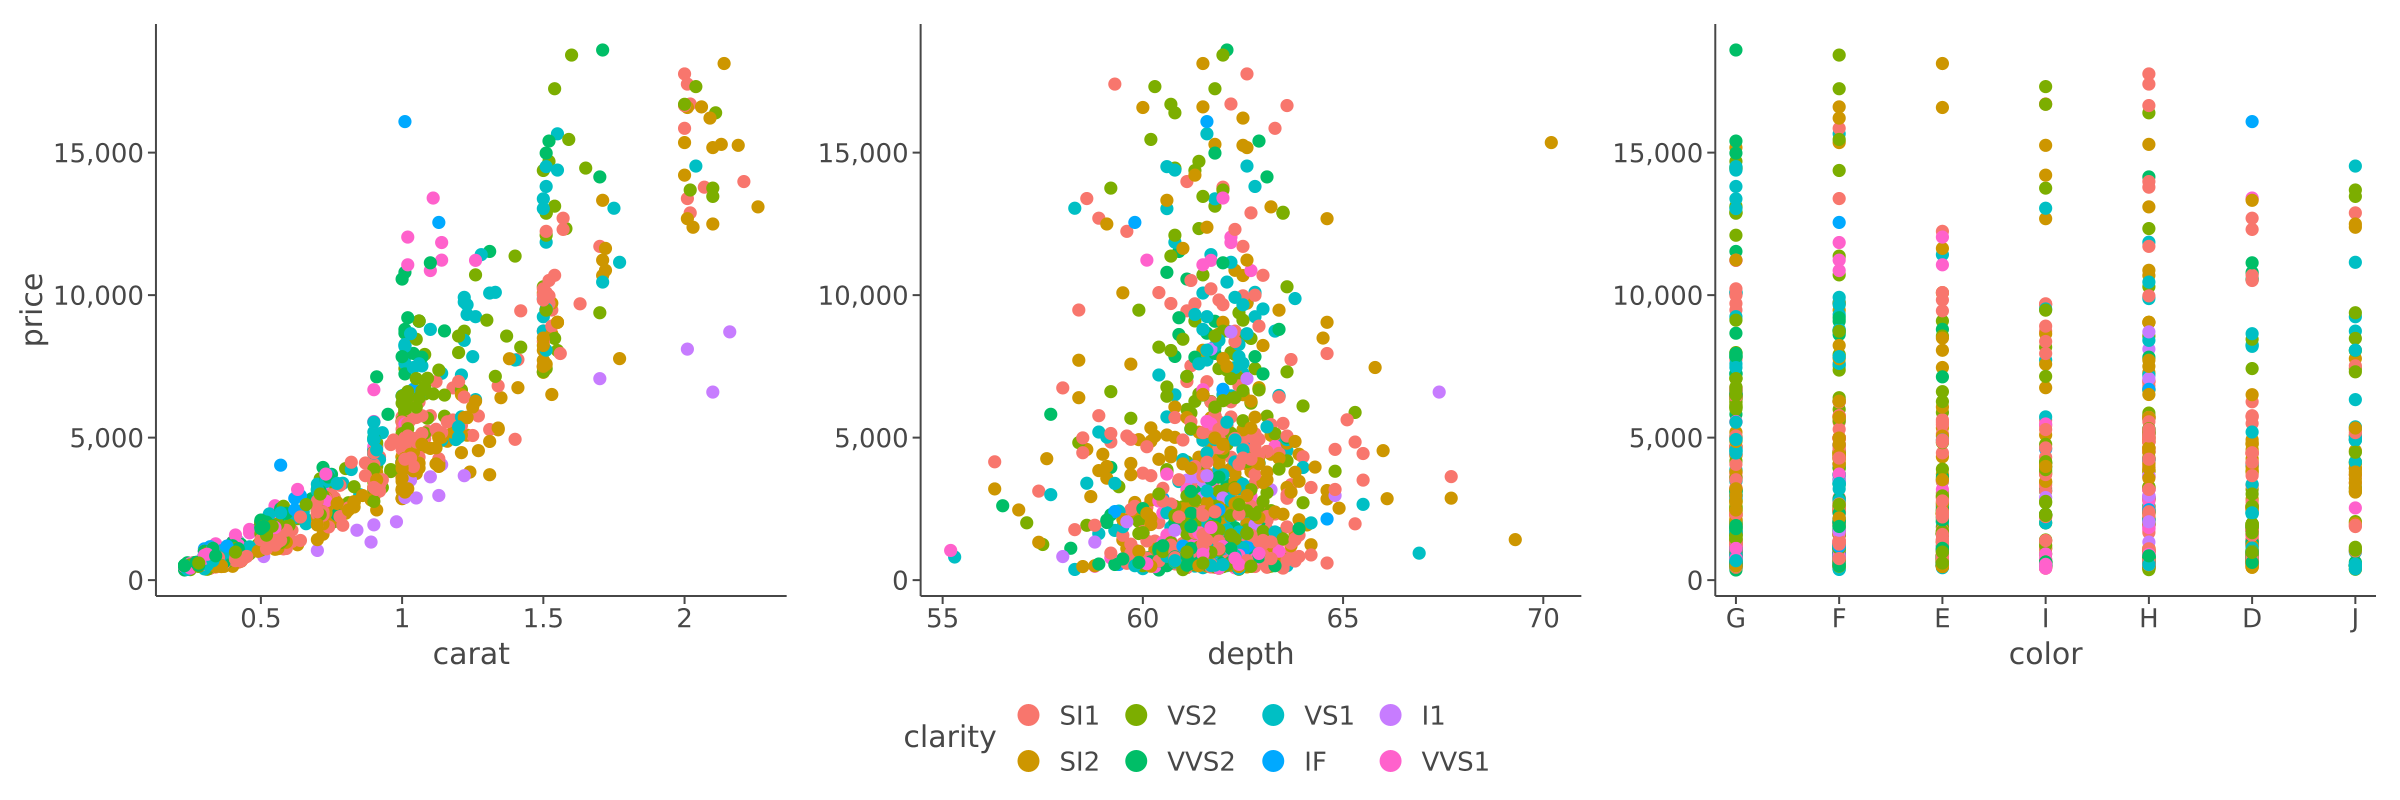

In [6]:
// Now collect the legends into a single shared legend.

// Note: 
// All 3 legends are visually identical (same title, labels, and aesthetic values), 
// so duplicates are removed and only one legend is shown.

gggrid(
    listOf(
        clarityP0,
        clarityP1 + theme(axisTitleY = "blank"),
        clarityP2 + theme(axisTitleY = "blank")
    ),
    
    guides = "collect"              // <-- collect legends from subplots

) + theme().legendPositionBottom()  // <-- also adjust the legend position 

#### 2. Collecting Colorbars


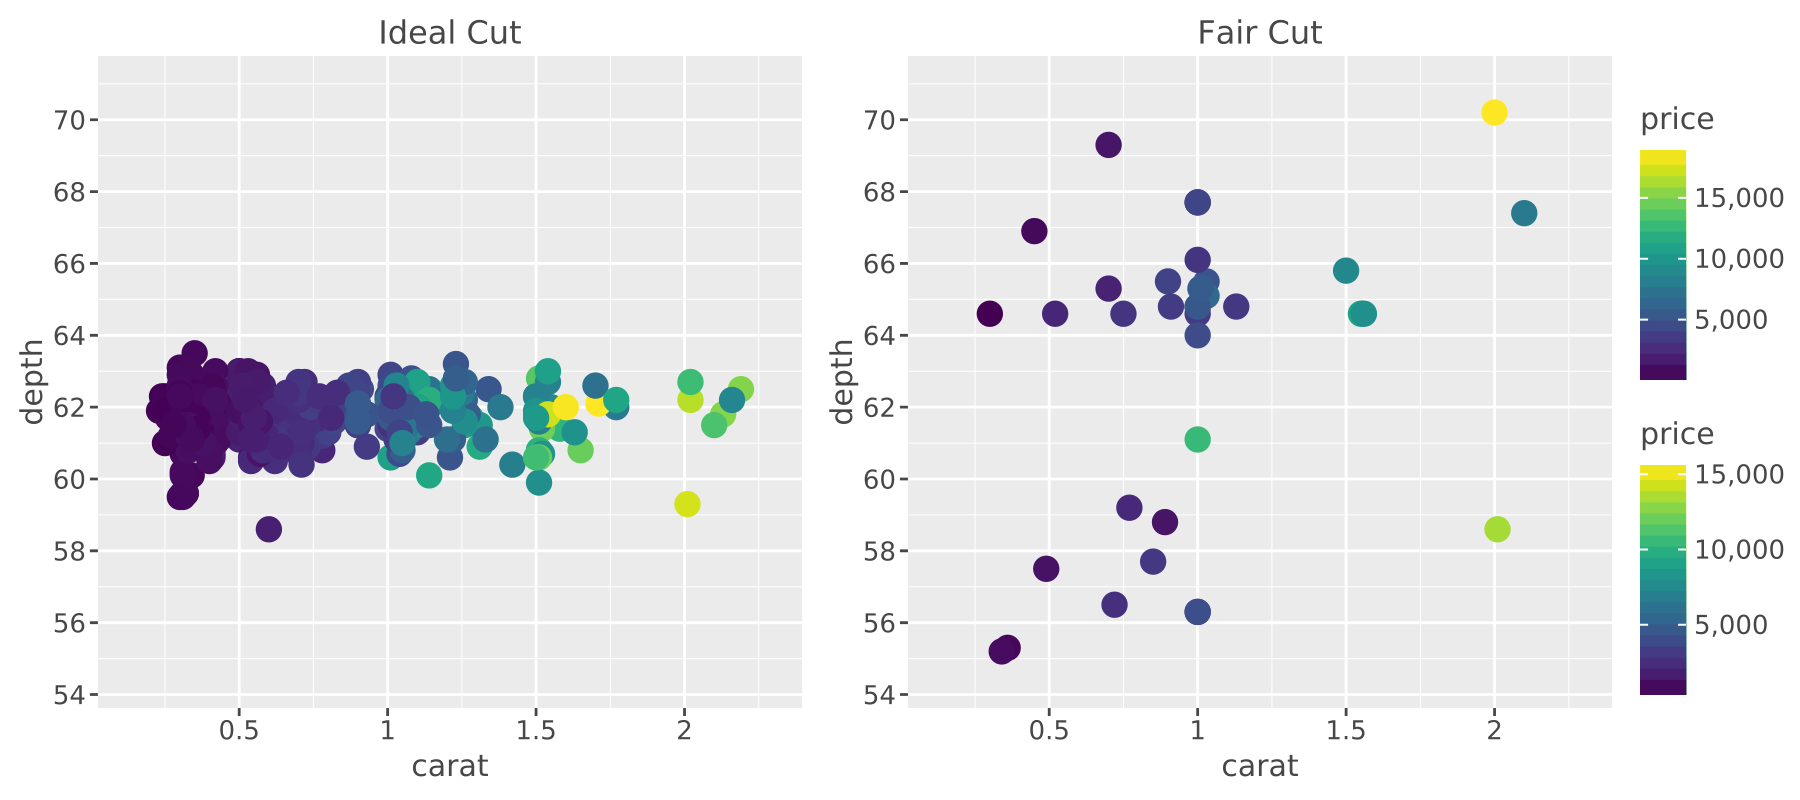

In [7]:
fun <T> DataFrame<T>.filterByColumnValue(columnName: String, value: Any?): DataFrame<T> =
    this.filter { it[columnName] == value }

val idealDiamonds = sampleDf.filterByColumnValue("cut", "Ideal").toMap()
val fairDiamonds = sampleDf.filterByColumnValue("cut", "Fair").toMap()

val priceP =
    letsPlot { x = "carat"; y = "depth"; color = "price" } +
        scaleColorViridis() +
        themeGrey() +
        theme(plotTitle = elementText(hjust = 0.5))

val priceP0 = priceP + geomPoint(data = idealDiamonds, size = 6.0) + ggtitle("Ideal Cut")
val priceP1 = priceP + geomPoint(data = fairDiamonds,  size = 6.0) + ggtitle("Fair Cut")

// Arrange two plots in a grid with guides="collect".

// Note: 
// The colorbars have different domain limits and breaks (due to different data ranges),
// so both are retained as separate colorbars.

gggrid(
    listOf(priceP0, priceP1),
    sharex = true, sharey = true,
    guides = "collect"
)


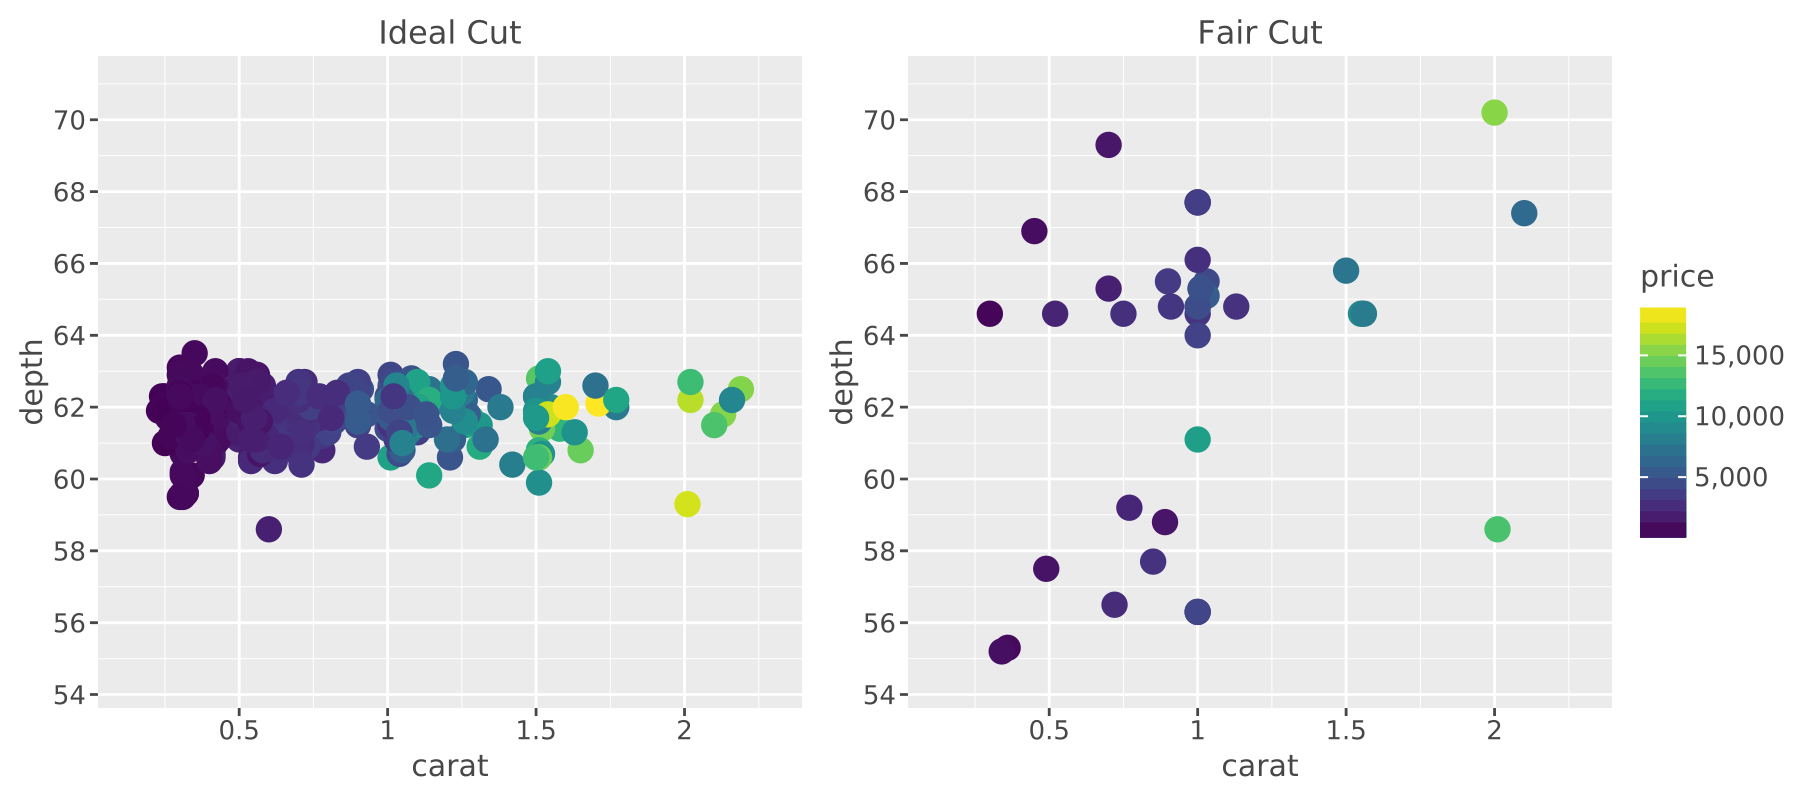

In [8]:
// Apply the same color scale limits to both subplots.
// Now both colorbars are visually identical, so the duplicate is removed.

fun List<Any?>.intMin() = this.minOf { it.toString().toInt() }
fun List<Any?>.intMax() = this.maxOf { it.toString().toInt() }

val priceLists = listOf(
    idealDiamonds["price"]!!,
    fairDiamonds["price"]!!
)

val priceMin = priceLists.minOf { it.intMin() }
val priceMax = priceLists.maxOf { it.intMax() }

val priceLims = scaleColorViridis(limits = listOf(priceMin, priceMax))

gggrid(
    listOf(
        priceP0 + priceLims, 
        priceP1 + priceLims
    ),
    sharex = true, sharey = true,
    guides = "collect"
)

#### 3. Collecting Guides in Nested Grids


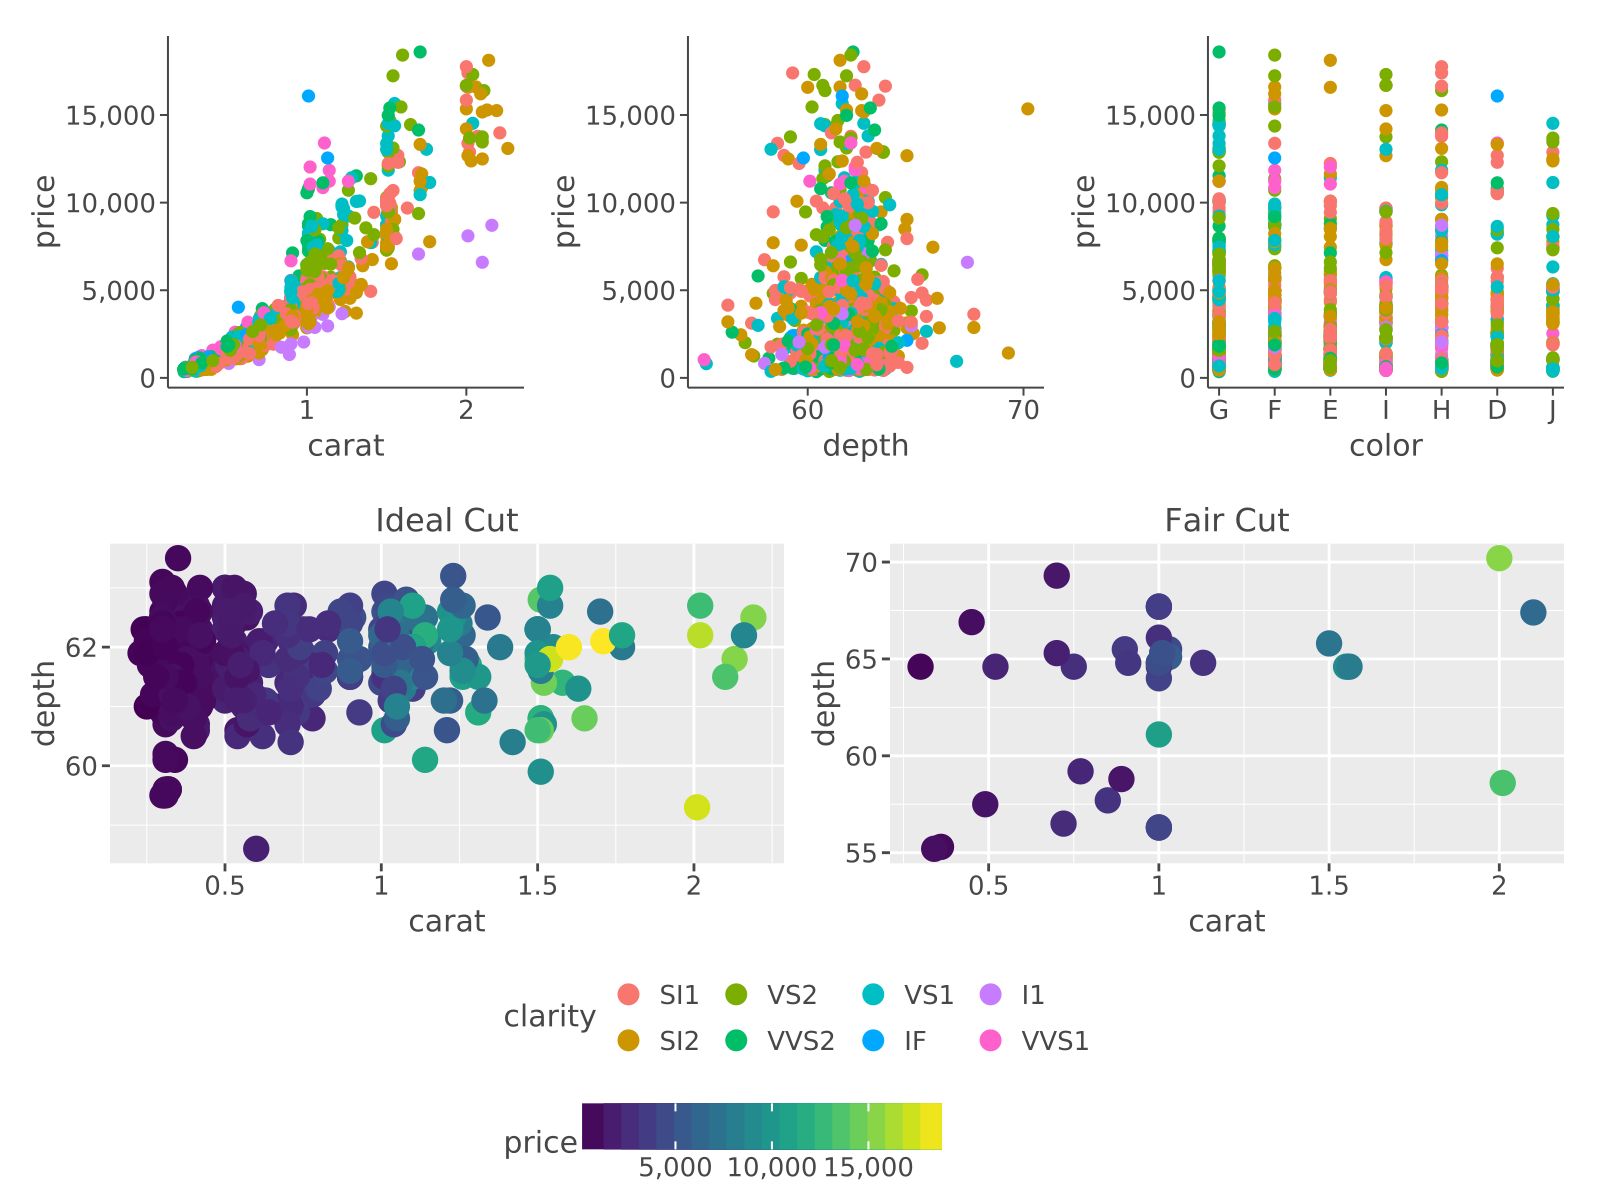

In [9]:
// Create nested grids and collect all guides at the top level.

val clarityGrid = gggrid(listOf(
    clarityP0, 
    clarityP1, 
    clarityP2
))

val priceGrid = gggrid(listOf(
    priceP0 + priceLims, 
    priceP1 + priceLims
))

// Top-level collects from both nested grids
gggrid(
    listOf(clarityGrid, priceGrid),
    ncol = 1,
    guides = "collect"  //  <-- collects from all nested grids
    
) + theme().legendPositionBottom() + ggsize(800, 600)


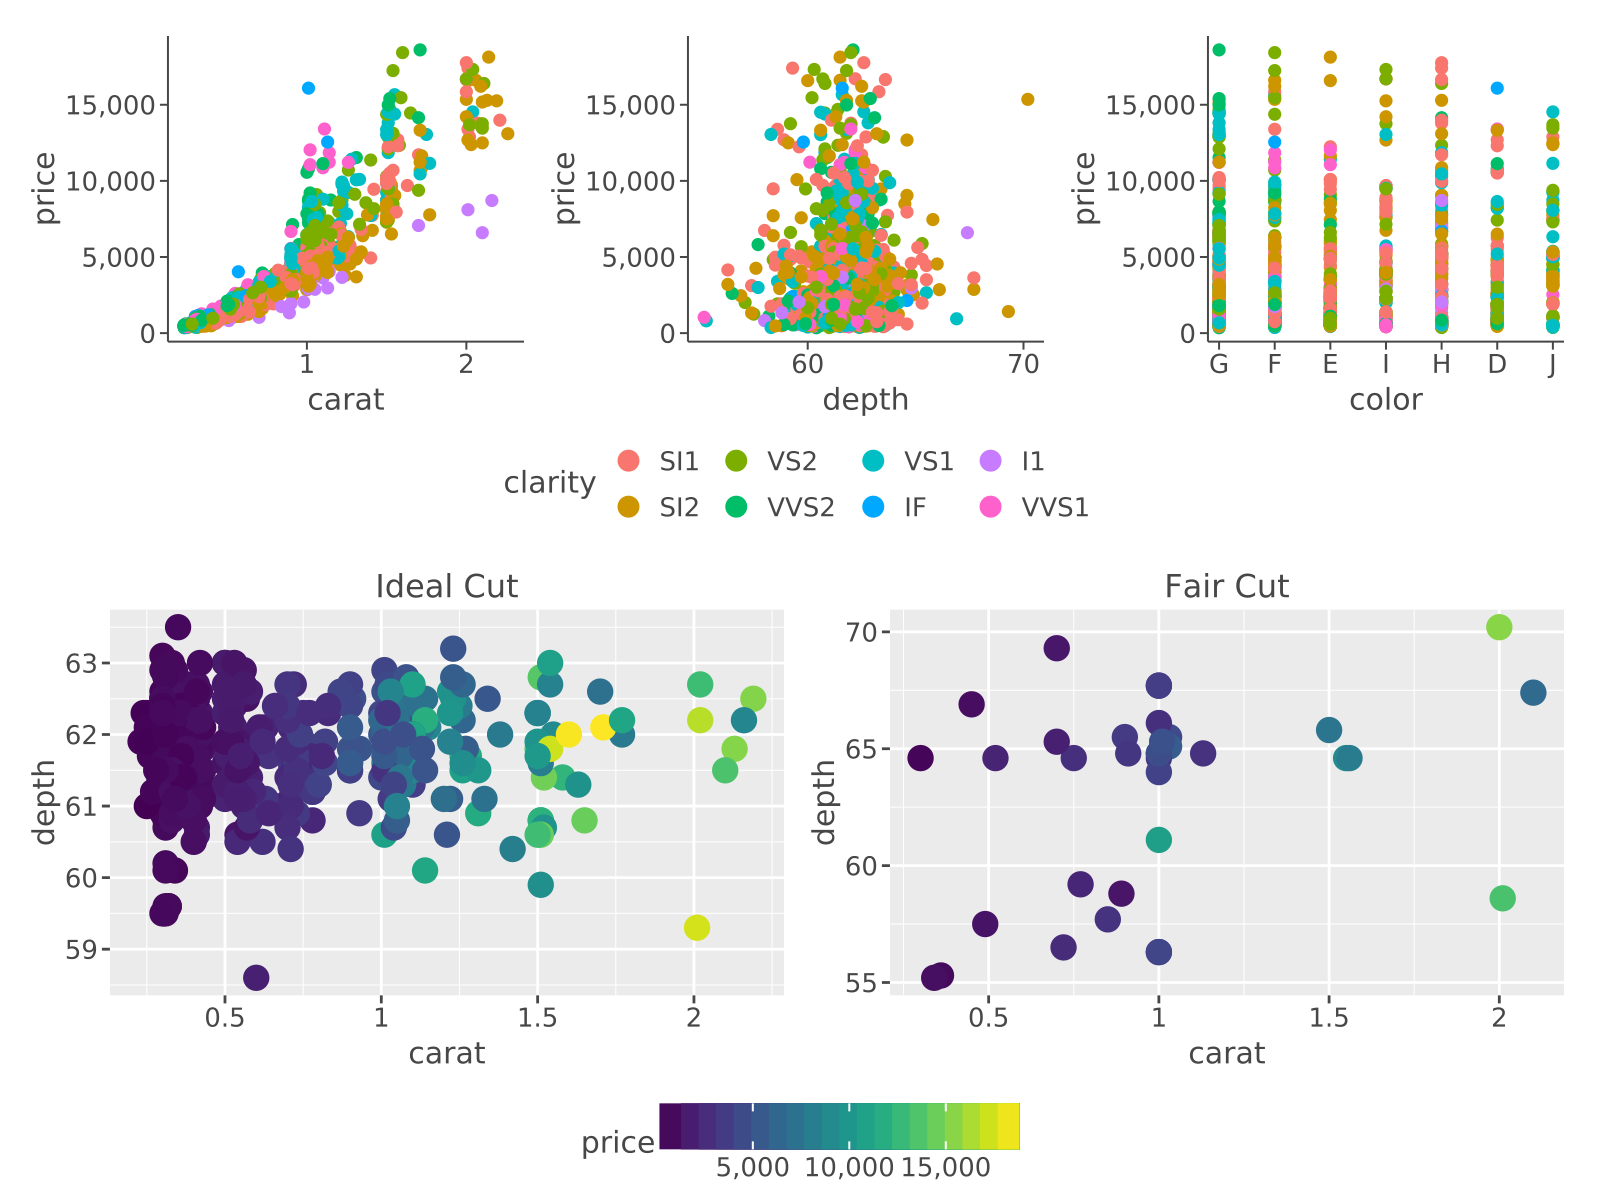

In [10]:
// A nested grid can override this behavior by collecting guides at its own level,
// keeping them separate from guides collected by the upper level.

val clarityGridLocalCollect = gggrid(listOf(
        clarityP0, 
        clarityP1, 
        clarityP2
    ),
                                     
    guides = "collect"      // <-- collect 'clarity' legends at this level
)

gggrid(listOf(
    clarityGridLocalCollect, 
    priceGrid
),
    ncol = 1,
    guides = "collect"
       
) + theme().legendPositionBottom() + ggsize(800, 600)